In [25]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np
import pandas as pd

from labellines import labelLines

import astropy.table as table

In [26]:
Grav_const = 6.67430e-11
kms_to_ms = 1000
pc_to_m = 3.086e16

In [27]:
''' 

Functions to calculate lines of constant surface brightness.
Mag_calculation requires:
  R_min: Minimum size in pc
  R_max: Largest size in pc
  mu: Surface brightness 

Used as:
  r,Mv = Mag_calculation(0.1,5000,27)
  plt.plot(r,Mv,ls='--')

'''

def Luminosity_calculation(r_values,mu, Mv_sol=4.83):
  from math import pi
  Luminosities = [2*pi*r*r*10**(-(mu-Mv_sol-21.572)/2.5) for r in r_values]
  return Luminosities

def absolute_calculation(Lums,Mv_sol=4.83):
  from math import log10
  absolute_mag = [Mv_sol - (2.5*log10(L)) for L in Lums]
  return absolute_mag

def Mag_calculation(R_min,R_max,mu):
  import numpy as np

  R_step=(R_max-R_min)/100
  R_values = np.arange(R_min,R_max,R_step)
  lums = Luminosity_calculation(R_values,mu)
  absolutes = absolute_calculation(lums)

  return R_values,absolutes

#function to load additional observational data

def extra_data():
    path = '../data/'
    data_path = '%s/gc_data.xlsx' %(path)
    df = pd.read_excel(data_path)
    df['cc'] = df['cc'].fillna(value='no')
    df['sp'] = df['sp'].fillna(value=0)
    GC_data = df[['ID','M_V,t','cc','r_h','R_Sun','sp']].dropna()
    mask = GC_data['R_Sun'] > 0
    for j,i in zip(GC_data.index[mask],mask):
        if i==True:
            GC_data.loc[j,"R_Sun"] = GC_data['R_Sun'][j]*1000
            GC_data.loc[j,"r_h"] = (GC_data['R_Sun'][j] * (GC_data['r_h'][j])*np.pi)/(60*180)
    extra_data = []
    with open('%s/m31gcs.dat' %(path),'r') as f:
      for line in f:
        if len(line.split())>2:
          extra_data.append([float(line.strip('\n').split()[1]),float(line.strip('\n').split()[2])])
    extra_data = pd.DataFrame(extra_data)
    extra_data = extra_data.rename(columns={0:'M_V,t',1:'r_h'})
    
    all_data = pd.concat([GC_data,extra_data])
    
    return all_data

# Function to load z=0 EDGE data

def load_data(flag):
  match flag:
    case 0:
      data_path = '../data/present_dwarf.data'
    case 1:
      data_path = '../data/present_GCD.data'
    case 2:
      data_path = '../data/present_GC.data'

  data = pd.read_csv(data_path)
  return data

# Function to calculate the line of sight velocity from Vx, Vy, and Vz velocities

def mean_los_calculation(sigma_vx, sigma_vy, sigma_vz):
  sq_sigma = (sigma_vx**2) + (sigma_vy**2) + (sigma_vz**2)
  sq_sigma = sq_sigma / 3
  return sq_sigma

# Calculate Luminosity from absolute magnitude values
def lum(m_x, m_x_sun=4.83):
  return pow(10., -0.4*(m_x - m_x_sun) )

# Function to calculate the dynamical mass estimate of EDGE objects

def EDGE_mass_dyn(data):

  vel = np.transpose([data["vx update"], data["vy update"], data["vz update"]])
  vel2 = np.transpose([data["Vx spread"], data["Vy spread"], data["Vz spread"]])
  mean_los = mean_los_calculation(*vel.T)
  mean_los_spread = mean_los_calculation(*vel2.T)
  mean_los[np.isnan(mean_los)] = mean_los_spread[np.isnan(mean_los)]
  
  half_light_dwarf = data["Projected Half-light radius"] * pc_to_m
  dyn_mass = (half_light_dwarf * (kms_to_ms**2) * mean_los  / Grav_const) / 1.989e30

  return dyn_mass




In [28]:
path = '../Data'

#---------------------------------------------------------------------------
# Load observational data - Andrew Pace Local Volume Data:
#---------------------------------------------------------------------------
dsph_mw = table.Table.read('https://raw.githubusercontent.com/apace7/local_volume_database/main/data/dwarf_mw.csv')
dsph_m31 = table.Table.read('https://raw.githubusercontent.com/apace7/local_volume_database/main/data/dwarf_m31.csv')
dsph_lf = table.Table.read('https://raw.githubusercontent.com/apace7/local_volume_database/main/data/dwarf_local_field.csv')
ufsc = table.Table.read('https://raw.githubusercontent.com/apace7/local_volume_database/main/data/gc_ambiguous.csv')
gc_disk = table.Table.read('https://raw.githubusercontent.com/apace7/local_volume_database/main/data/gc_mw_new.csv')
gc_harris = table.Table.read('https://raw.githubusercontent.com/apace7/local_volume_database/main/data/gc_harris.csv')

# Calculate dynamical mass as per the Local Volume Database

def mass_dyn(d):
  return d['vlos_sigma']**2*930*d['rhalf']*np.sqrt(1.-d['ellipticity'])* d['distance']*np.pi/180./60.*1000.
dsph_mw['mass_dynamical'] = mass_dyn(dsph_mw)
dsph_m31['mass_dynamical'] = mass_dyn(dsph_m31)
dsph_lf['mass_dynamical'] = mass_dyn(dsph_lf)
ufsc['mass_dynamical'] = mass_dyn(ufsc)
def mass_dyn(d):
  return d['vlos_sigma']**2*930*d['rhalf']*d['distance']*np.pi/180./60.*1000.
gc_disk['mass_dynamical'] = mass_dyn(gc_disk)
gc_harris['mass_dynamical'] = mass_dyn(gc_harris)

In [29]:
# load additional data
GC_data = extra_data()

In [39]:
# Set plotting variables
fontsize = 7
lw = 1.5
plt.rc('text', usetex=False)
plt.rc('font', family='serif')

plt.rcParams['font.family'] = 'Helvetica'
plt.rcParams['font.serif'] = ['Helvetica regular']

# plt.rcParams['mathtext.fontset'] = 'Helvetica'
# plt.rcParams['mathtext.family'] = 'Helvetica'
plt.rcParams['font.size'] = fontsize
plt.rcParams['axes.labelsize'] = fontsize
plt.rcParams['axes.linewidth'] = lw
plt.rcParams['lines.linewidth'] = lw
plt.rcParams['lines.markersize'] = 3
plt.rcParams['xtick.labelsize'] = fontsize - 1
plt.rcParams['ytick.labelsize'] = fontsize - 1
plt.rcParams['xtick.major.width'] = lw
plt.rcParams['xtick.minor.width'] = lw * (2/3.)
plt.rcParams['ytick.major.width'] = lw
plt.rcParams['ytick.minor.width'] = lw * (2/3.)
plt.rcParams['legend.fontsize'] = fontsize

size = (plt.rcParams['lines.markersize']**2)*6
cbar_min, cbar_max = -5, 0

from matplotlib.font_manager import FontProperties
helvetica_path = '../../../fonts/Helvetica.ttf'
helvetica = FontProperties(helvetica_path)

kwargsa = {'marker':'o', 'color':'green', 'alpha':0.25, 'edgecolor':'black'}
kwargsb = {'marker':'D', 'color':'red', 'alpha':0.25, 'edgecolor':'black'}
kwargsc = {'marker':'D', 'color':'gray', 'alpha':0.25, 'edgecolor':'black'}


In [40]:
# Load EDGE data
present_dwarfs = load_data(0)
present_GCDs = load_data(1)
present_GCs = load_data(2)

# Set EDGE data plotting styles

kwargs1 = {'vmax':cbar_max, 'vmin':cbar_min, 'cmap':'viridis', 'marker':'v', 'edgecolor':'red', 'linewidth':1, 's':size, 'c':np.log10(present_dwarfs['Total Stellar Mass Fraction'])}
kwargs2 = {'vmax':cbar_max, 'vmin':cbar_min, 'cmap':'viridis', 'marker':'v', 'edgecolor':'blue', 'linewidth':1, 's':size, 'c':np.log10(present_GCDs['Total Stellar Mass Fraction'])}
kwargs3 = {'vmax':cbar_max, 'vmin':cbar_min, 'cmap':'viridis', 'marker':'v', 'edgecolor':'green', 'linewidth':1, 's':size, 'c':np.log10(present_GCs['Total Stellar Mass Fraction'])}

<>:15: SyntaxWarning: invalid escape sequence '\m'
<>:87: SyntaxWarning: invalid escape sequence '\m'
<>:88: SyntaxWarning: invalid escape sequence '\m'
<>:90: SyntaxWarning: invalid escape sequence '\m'
<>:90: SyntaxWarning: invalid escape sequence '\m'
<>:90: SyntaxWarning: invalid escape sequence '\m'
<>:90: SyntaxWarning: invalid escape sequence '\m'
<>:90: SyntaxWarning: invalid escape sequence '\m'
<>:90: SyntaxWarning: invalid escape sequence '\m'
<>:90: SyntaxWarning: invalid escape sequence '\m'
<>:163: SyntaxWarning: invalid escape sequence '\l'
<>:15: SyntaxWarning: invalid escape sequence '\m'
<>:87: SyntaxWarning: invalid escape sequence '\m'
<>:88: SyntaxWarning: invalid escape sequence '\m'
<>:90: SyntaxWarning: invalid escape sequence '\m'
<>:90: SyntaxWarning: invalid escape sequence '\m'
<>:90: SyntaxWarning: invalid escape sequence '\m'
<>:90: SyntaxWarning: invalid escape sequence '\m'
<>:90: SyntaxWarning: invalid escape sequence '\m'
<>:90: SyntaxWarning: invalid 

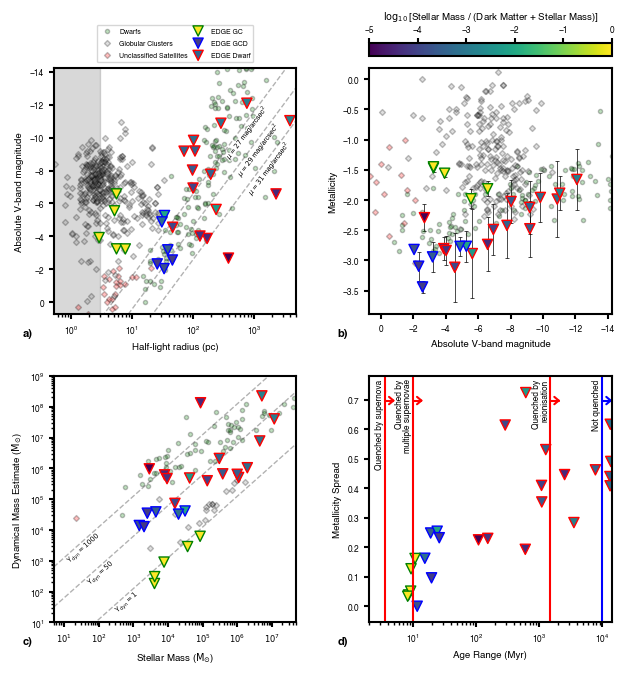

In [62]:
# Initialise figure
fig, ax = plt.subplots(figsize=(7.2,7.2), nrows=2, ncols=2, gridspec_kw={'hspace':0.25, 'wspace':0.3})

#---------------------------------------------------------------------------

# Panel A:
#---------------------------------------------------------------------------
axis = (0,0)

# Add surface brightness guidelines:
x_min, x_max = 0.5188915205952385, 5e3 #500
kwargs = {'ls':'--', 'color':'black', 'alpha':0.3, 'linewidth':1, 'zorder':0}
mags = Mag_calculation(x_min,x_max,27)
for i in [27, 29, 31]:
  ax[axis].plot(*Mag_calculation(x_min,x_max,i), label='$\mu=%s$ mag/arcsec$^{2}$' % i, **kwargs)
kwargs = {'align':True, 'alpha':1, 'fontsize':fontsize-2, 'va':'top', 'ha':'right', 'zorder':5, 'outline_width':1.5}

#add surface brightness labels
labelLines(ax[axis].get_lines(), xvals=(1.3*10**3,2*10**3,3*10**3),**kwargs)

# Add observational data points:
ax[axis].scatter(dsph_mw['rhalf_sph_physical'], dsph_mw['M_V'], label=r'${\rm Dwarf~MW}$', **kwargsa)
ax[axis].scatter(dsph_m31['rhalf_sph_physical'], dsph_m31['M_V'], label=r'${\rm Dwarf~M31}$', **kwargsa)
dw_point = ax[axis].scatter(dsph_lf['rhalf_sph_physical'], dsph_lf['M_V'], label=r'${\rm Dwarf~LF}$', **kwargsa)
ufsc_point = ax[axis].scatter(ufsc['rhalf_sph_physical'], ufsc['M_V'], label=r'${\rm UFSC}$', **kwargsb)
ax[axis].scatter(gc_disk['rhalf_sph_physical'], gc_disk['M_V'], label=r'${\rm GC~Disk}$', **kwargsc)
gc_point = ax[axis].scatter(gc_harris['rhalf_sph_physical'], gc_harris['M_V'], label=r'${\rm GC~Harris}$', **kwargsc)
ax[axis].scatter(GC_data['r_h'], GC_data['M_V,t'], **kwargsc)

# EDGE data:
EDGE_point = ax[axis].scatter(present_dwarfs['Projected Half-light radius'], present_dwarfs['Mv'], **kwargs1)
DMC_point = ax[axis].scatter(present_GCDs['Projected Half-light radius'], present_GCDs['Mv'], **kwargs2)
ax[axis].scatter(present_GCs['Projected Half-light radius'], present_GCs['Mv'], **kwargs3)

# Misc:
ax[axis].set_xscale('log')
ax[axis].set_xlabel('Half-light radius (pc)')
ax[axis].set_ylabel('Absolute V-band magnitude')
ax[axis].set_ylim([0.7418468381679413, -14.241846838167941])
ax[axis].set_xlim([x_min, x_max])

# Shade resolution limit
ax[axis].fill_betweenx(y=[-15,1], x1=0.001, x2=3, color='gray', facecolor='gray', alpha=0.3, zorder=0)
#---------------------------------------------------------------------------

# Panel B:
#---------------------------------------------------------------------------
axis = (0,1)

# Observational data points:
ax[axis].scatter(dsph_mw['M_V'], dsph_mw['metallicity'], label=r'${\rm Dwarf~MW}$', **kwargsa)
ax[axis].scatter(dsph_m31['M_V'], dsph_m31['metallicity'], label=r'${\rm Dwarf~M31}$', **kwargsa)
dw_point = ax[axis].scatter(dsph_lf['M_V'], dsph_lf['metallicity'], label=r'${\rm Dwarf~LF}$', **kwargsa)
ufsc_point = ax[axis].scatter(ufsc['M_V'], ufsc['metallicity'], label=r'${\rm UFSC}$', **kwargsb)
ax[axis].scatter(gc_disk['M_V'], gc_disk['metallicity'], label=r'${\rm GC~Disk}$', **kwargsc)
gc_point = ax[axis].scatter(gc_harris['M_V'], gc_harris['metallicity'], label=r'${\rm GC~Harris}$', **kwargsc)

# EDGE data points:
EDGE_point = ax[axis].scatter(present_dwarfs['Mv'], present_dwarfs['Mean [Fe/H]'], **kwargs1)
DMC_point = ax[axis].scatter(present_GCDs['Mv'], present_GCDs['Mean [Fe/H]'], **kwargs2)
GC_points = ax[axis].scatter(present_GCs['Mv'], present_GCs['Mean [Fe/H]'], **kwargs3)

# Include y-errorbars on this panel:
kwargs = {'ecolor':'black', 'elinewidth':0.5, 'capsize':1.5, 'capthick':0.5, 'linewidth':0, 'zorder':0}

ax[axis].errorbar(present_dwarfs['Mv'], present_dwarfs['Mean [Fe/H]'], yerr=present_dwarfs['[Fe/H] Spread Weighted'], **kwargs)
ax[axis].errorbar(present_GCDs['Mv'], present_GCDs['Mean [Fe/H]'], yerr=present_GCDs['[Fe/H] Spread Weighted'], **kwargs)
ax[axis].errorbar(present_GCs['Mv'], present_GCs['Mean [Fe/H]'], yerr=present_GCs['[Fe/H] Spread Weighted'], **kwargs)

# Misc:
ax[axis].set_xlabel('Absolute V-band magnitude')
ax[axis].set_ylabel('Metallicity')
ax[axis].set_xlim([0.7418468381679413, -14.241846838167941])
ax[axis].set_ylim([-3.890771559766233, 0.18527483617934443])
#---------------------------------------------------------------------------

# Panel C:
#---------------------------------------------------------------------------
axis = (1,0)

# Misc:
ax[axis].set_xlim(5e0, 5e7)
ax[axis].set_ylim(1e1, 1e9)
ax[axis].set_xscale('log')
ax[axis].set_yscale('log')

ax[axis].set_ylabel('Dynamical Mass Estimate ($\mathrm{M_{\odot}}$)')
ax[axis].set_xlabel('Stellar Mass ($\mathrm{M_{\odot}}$)')

ax[axis].set_xticks([1e1,1e2,1e3,1e4,1e5,1e6,1e7], ['$\mathrm{10^1}$','$\mathrm{10^2}$','$\mathrm{10^3}$','$\mathrm{10^4}$','$\mathrm{10^5}$','$\mathrm{10^6}$','$\mathrm{10^7}$'])

# Add upsilon guidelines:
kwargs = {'ls':'--', 'color':'black', 'alpha':0.3, 'linewidth':1, 'zorder':0}
x = ax[axis].get_xlim()
for i in [1000, 50, 1]:
  y = (i*x[0] / 8, i*x[1] / 8)
  ax[axis].plot(x, y, label=r'$\Upsilon_{\rm{dyn}}=%i$' % i, **kwargs)
kwargs = {'align':True, 'alpha':1, 'fontsize':fontsize-2, 'va':'top', 'ha':'right', 'zorder':5, 'outline_width':1.5}
labelLines(ax[axis].get_lines(), xvals=(8*10**1,2*10**2,10**3), **kwargs)

# Observational data:
ax[axis].scatter(2.*lum(dsph_mw['M_V']), dsph_mw['mass_dynamical'], label=r'${\rm Dwarf~MW}$', **kwargsa)
ax[axis].scatter(2.*lum(dsph_m31['M_V']), dsph_m31['mass_dynamical'], label=r'${\rm Dwarf~M31}$', **kwargsa)
dw_point = ax[axis].scatter(dsph_lf['M_V'], dsph_lf['mass_dynamical'], label=r'${\rm Dwarf~LF}$', **kwargsa)
ufsc_point = ax[axis].scatter(2.*lum(ufsc['M_V']), ufsc['mass_dynamical'], label=r'${\rm UFSC}$', **kwargsb)
ax[axis].scatter(gc_disk['M_V'], gc_disk['mass_dynamical'], label=r'${\rm GC~Disk}$', **kwargsc)
gc_point = ax[axis].scatter(2*lum(gc_harris['M_V']), gc_harris['mass_dynamical'], label=r'${\rm GC~Harris}$', **kwargsc)

# EDGE data:
EDGE_point = ax[axis].scatter(10**present_dwarfs['Total Stellar Mass'], EDGE_mass_dyn(present_dwarfs), **kwargs1)
DMC_point = ax[axis].scatter(10**present_GCDs['Total Stellar Mass'], EDGE_mass_dyn(present_GCDs), **kwargs2)
GC_point = ax[axis].scatter(10**present_GCs['Total Stellar Mass'], EDGE_mass_dyn(present_GCs), **kwargs3)
#---------------------------------------------------------------------------

# Panel D:
#---------------------------------------------------------------------------
axis = (1,1)

ax[axis].set_xscale("log")

type='Range'
EDGE_point = ax[axis].scatter(present_dwarfs['Age %s' % type], present_dwarfs['[Fe/H] Spread'], **kwargs1)
DMC_point = ax[axis].scatter(present_GCDs['Age %s' % type], present_GCDs['[Fe/H] Spread'], **kwargs2)
GC_point = ax[axis].scatter(present_GCs['Age %s' % type], present_GCs['[Fe/H] Spread'], **kwargs3)

# Axis Labels
ax[axis].set_xlabel('Age Range (Myr)')
ax[axis].set_ylabel('Metallicity Spread')

# Make some silly epoch lines with arrows:
kwargs = {'va':'top', 'ha':'right', 'fontsize':fontsize-1, 'rotation':90, 'linespacing':0.8}
times = [3.6, 10, 1.5e3, 1e4]
labels = ['Quenched by supernova', 'Quenched by\nmultiple supernovae', 'Quenched by\nreionisation', 'Not quenched']
for time, label in zip(times, labels):
  c = 'blue' if 'Not' in label else 'red'
  ax[axis].axvline(time, ls='-', c=c)
  ax[axis].plot([time, time*1.35], [0.9, 0.9], transform=ax[axis].get_xaxis_transform(), lw=lw, color=c, solid_capstyle='round')
  ax[axis].plot([time*1.35, time*1.15], [0.9, 0.915], transform=ax[axis].get_xaxis_transform(), lw=lw, color=c, solid_capstyle='round')
  ax[axis].plot([time*1.35, time*1.15], [0.9, 0.885], transform=ax[axis].get_xaxis_transform(), lw=lw, color=c, solid_capstyle='round')
  ax[axis].text(time*0.95, 0.99, label, transform=ax[axis].get_xaxis_transform(), color='black', **kwargs)

ax[axis].set_xlim([2, 1.4e4])
ax[axis].set_ylim(-0.054407707645003446, 0.78)
#---------------------------------------------------------------------------

for axes in np.ravel(ax):
  axes.set_aspect('auto')

# Legend:
#---------------------------------------------------------------------------
data_points = [dw_point, gc_point, ufsc_point, GC_point, DMC_point, EDGE_point]
data_labels = ['Dwarfs','Globular Clusters','Unclassified Satellites', 'EDGE GC', 'EDGE GCD', 'EDGE Dwarf']
bbox = (0.5, 1.01)
ax[0,0].legend(data_points, data_labels, loc='lower center', fontsize=fontsize-2, ncol=2, columnspacing=0.5,bbox_to_anchor=bbox,labelspacing=0.75)
#---------------------------------------------------------------------------

# Colourbar:
#---------------------------------------------------------------------------
norm = mpl.colors.Normalize(vmin=cbar_min, vmax=cbar_max)
sm = cm.ScalarMappable(norm=norm, cmap=cm.viridis)
sm.set_array([])

clabel = '$\log_{10}$[Stellar Mass / (Dark Matter + Stellar Mass)]'
width = 0.05
pad = 0.05
l, b, w, h = ax[0,1].get_position().bounds
position = 'top'
cax = fig.add_axes([l, b+h+h*pad, w, h*width])
cbar = plt.colorbar(sm, cax=cax, orientation='horizontal')
cbar.set_label(clabel, fontsize=fontsize)
cbar.ax.tick_params(labelsize=fontsize-1)
cax.xaxis.set_label_position('top')
cax.xaxis.set_ticks_position('top')
#---------------------------------------------------------------------------

# Panel labels:
#---------------------------------------------------------------------------
pad = (-0.13, -0.09)
labels = ['a)', 'b)', 'c)', 'd)']
for axes, label in zip(np.ravel(ax), labels):
  axes.text(*pad, label, fontsize=8, transform=axes.transAxes, clip_on=False, fontweight="bold")
#---------------------------------------------------------------------------

plt.savefig('../figures/Fig1.pdf', bbox_inches='tight')
plt.savefig('../figures/Fig1.png', bbox_inches='tight',dpi=750)